In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---ファイルの読み込むパスを指定---
file_path_left_device = "WearableDevices/oba_l_left_foot_data.csv"
file_path_right_device = "WearableDevices/oba_l_right_foot_data.csv"
file_path_mocap = "MotionCaptures/oba_l_mocap.csv"
file_path_force = "3DGroundForces/oba_l_force.csv"

# ---CSVファイルの読み込み---
df_left_device = pd.read_csv(file_path_left_device, header=0)
df_right_device = pd.read_csv(file_path_right_device, header=0)
df_mocap = pd.read_csv(file_path_mocap, header=[2, 5, 6])
df_force = pd.read_csv(file_path_force, header=10, encoding='shift_jis')

In [273]:
"""
# ---モーションキャプチャデータの列名を整理---
"""
new_columns = []

for col in df_mocap.columns:
    # col[0]: Rigid Body 001, col[1]: Position, col[2]: X
    
    # 1. FrameとTimeはそのまま
    if col[2] == 'Frame':
        new_columns.append('Frame')
    elif 'Time' in col[2]:
        new_columns.append('Time (Seconds)')
        
    # 2. それ以外は "Rigid Body " を削除して番号だけにする
    else:
        # "Rigid Body " を空文字に置換し、前後の空白も削除
        body_num = col[0].replace('Rigid Body', '').strip()
        
        # 例: 001_Position_X
        name = f"{body_num}_{col[1]}_{col[2]}"
        new_columns.append(name)

# 列名を更新
df_mocap.columns = new_columns

print(df_mocap.columns)

Index(['Frame', 'Time (Seconds)', '001_Rotation_X', '001_Rotation_Y',
       '001_Rotation_Z', '001_Position_X', '001_Position_Y', '001_Position_Z',
       '002_Rotation_X', '002_Rotation_Y', '002_Rotation_Z', '002_Position_X',
       '002_Position_Y', '002_Position_Z', '003_Rotation_X', '003_Rotation_Y',
       '003_Rotation_Z', '003_Position_X', '003_Position_Y', '003_Position_Z',
       '004_Rotation_X', '004_Rotation_Y', '004_Rotation_Z', '004_Position_X',
       '004_Position_Y', '004_Position_Z', '005_Rotation_X', '005_Rotation_Y',
       '005_Rotation_Z', '005_Position_X', '005_Position_Y', '005_Position_Z',
       '006_Rotation_X', '006_Rotation_Y', '006_Rotation_Z', '006_Position_X',
       '006_Position_Y', '006_Position_Z', '007_Rotation_X', '007_Rotation_Y',
       '007_Rotation_Z', '007_Position_X', '007_Position_Y', '007_Position_Z',
       '008_Rotation_X', '008_Rotation_Y', '008_Rotation_Z', '008_Position_X',
       '008_Position_Y', '008_Position_Z', '009_Rotation_X', 

In [274]:
"""
# ---地面反力データの列名を整理---
"""
columns_mapping = {
    'Unnamed: 0': 'Time (Seconds)',
    '右-Fx': 'Right_Fx',
    '右-Fy': 'Right_Fy',
    '右-Fz': 'Right_Fz',
    '右-Mx': 'Right_Mx',
    '右-My': 'Right_My',
    '右-Mz': 'Right_Mz',
    '右-COPx': 'Right_COPx',
    '右-COPy': 'Right_COPy',
    '左-Fx': 'Left_Fx',
    '左-Fy': 'Left_Fy',
    '左-Fz': 'Left_Fz',
    '左-Mx': 'Left_Mx',
    '左-My': 'Left_My',
    '左-Mz': 'Left_Mz',
    '左-COPx': 'Left_COPx',
    '左-COPy': 'Left_COPy',
    '右-速度計': 'Right_SpeedMeter',
    '左-速度計': 'Left_SpeedMeter',
    '右-外部制御': 'Right_ExtControl',
    '左-外部制御': 'Left_ExtControl',
    '右-速度': 'Right_Speed',
    '左-速度': 'Left_Speed',
    '右-実速度': 'Right_ActualSpeed',
    '左-実速度': 'Left_ActualSpeed',
    '右-実効負荷率': 'Right_EffLoadRatio',
    '右-ピーク負荷率': 'Right_PeakLoadRatio',
    '右-消費電力': 'Right_Power',
    '左-実効負荷率': 'Left_EffLoadRatio',
    '左-ピーク負荷率': 'Left_PeakLoadRatio',
    '左-消費電力': 'Left_Power',
    'アナログ入力1': 'Analog1'
}

df_force = df_force.rename(columns=columns_mapping)
print(df_force.columns)

Index(['Time (Seconds)', 'Right_Fx', 'Right_Fy', 'Right_Fz', 'Right_Mx',
       'Right_My', 'Right_Mz', 'Right_COPx', 'Right_COPy', 'Left_Fx',
       'Left_Fy', 'Left_Fz', 'Left_Mx', 'Left_My', 'Left_Mz', 'Left_COPx',
       'Left_COPy', 'Right_SpeedMeter', 'Left_SpeedMeter', 'Right_ExtControl',
       'Left_ExtControl', 'Right_Speed', 'Left_Speed', 'Right_ActualSpeed',
       'Left_ActualSpeed', 'Right_EffLoadRatio', 'Right_PeakLoadRatio',
       'Right_Power', 'Left_EffLoadRatio', 'Left_PeakLoadRatio', 'Left_Power',
       'Analog1'],
      dtype='object')


In [275]:
from scipy.interpolate import interp1d

def process_resampling(df_input, sampling_interval=10):
    """
    データフレームを受け取り、リサンプリングと単位変換を行って返す関数,、および軸の反転を行って返す関数
    df_input: ElapsedTime (ms)
    """
    # 元のデータを変更しないようにコピーを作成
    df = df_input.copy()

    # --- 1. 欠損値の補完（リサンプリング前） ---
    # Marker列を除外して線形補完
    exclude_cols = ['Marker']
    target_cols = df.columns.difference(exclude_cols)
    
    # 補完処理
    df[target_cols] = df[target_cols].interpolate(method='linear', axis=0)

    # --- 2. 新しい時間軸の作成 (100Hz = 10ms) ---
    time_min = 0
    time_max = df['ElapsedTime'].max()
    new_time = np.arange(time_min, time_max, sampling_interval)
    
    # 新しい時間軸を持つDataFrameを作成
    df_resampled = pd.DataFrame({'ElapsedTime': new_time})

    # --- 3. マーカー列（不連続データ）の処理 ---
    # マーカー列が存在する場合のみ処理を行う
    if exclude_cols:
        df_markers = df[['ElapsedTime'] + exclude_cols].dropna(subset=exclude_cols, how='all').copy()
        
        # マーカーのタイミングを新しいサンプリングレートのグリッドに丸める
        df_markers['ElapsedTime_rounded'] = (df_markers['ElapsedTime'] / sampling_interval).round() * sampling_interval
        # 同じタイミングに重複した場合の処理（重複削除）
        df_markers = df_markers.drop_duplicates(subset=['ElapsedTime_rounded'])
        
        # 結合用のキーを作成 (整数化して浮動小数点の誤差を回避)
        df_resampled['MergeKey'] = df_resampled['ElapsedTime'].round().astype(int)
        df_markers['MergeKey'] = df_markers['ElapsedTime_rounded'].round().astype(int)
        
        # マーカー情報を結合
        df_resampled = pd.merge(
            df_resampled,
            df_markers[['MergeKey'] + exclude_cols],
            left_on='MergeKey',
            right_on='MergeKey',
            how='left'
        )
        # 不要なキーを削除
        df_resampled = df_resampled.drop(columns=['MergeKey'])

    # --- 4. 連続値データの補間 (interp1d) ---
    # 補間から除外するカラム（時間とマーカー）
    columns_to_exclude = ['ElapsedTime'] + exclude_cols
    
    for column in df.columns:
        if column in columns_to_exclude:
            continue
        
        # interp1dによる線形補間関数作成 (外挿あり)
        interpolator = interp1d(df['ElapsedTime'], df[column], 
                                kind='linear', 
                                fill_value='extrapolate')
        
        # 新しい時間軸で値を計算して代入
        df_resampled[column] = interpolator(new_time)

    # --- 5. 単位変換とリネーム ---
    # ms -> s
    df_resampled['ElapsedTime'] = df_resampled['ElapsedTime'] / 1000
    # カラム名変更
    df_resampled = df_resampled.rename(columns={'ElapsedTime': 'Time (Seconds)'})

    # --- 6. 軸のマッピング変更（追加部分） ---
    # AccelとGyroのX軸を反転 (-1倍)
    # 左右それぞれのカラム名を指定
    invert_targets = [
        'Left_Accel_X', 'Left_Gyro_X', 
        'Right_Accel_X', 'Right_Gyro_X'
    ]
    
    # データフレームに含まれているカラムのみ処理を実行（エラー回避）
    cols_to_invert = [col for col in invert_targets if col in df_resampled.columns]
    
    if cols_to_invert:
        df_resampled[cols_to_invert] = df_resampled[cols_to_invert] * -1

    return df_resampled

# 関数を適用して左右それぞれ処理
df_left_processed = process_resampling(df_left_device, sampling_interval=10)
df_right_processed = process_resampling(df_right_device, sampling_interval=10)

# 結果の確認
print("Left Data Columns:", df_left_processed.columns)
print("Right Data Columns:", df_right_processed.columns)
print(df_left_processed.head())

Left Data Columns: Index(['Time (Seconds)', 'Marker', 'Left_kPa_1', 'Left_kPa_2', 'Left_kPa_3',
       'Left_kPa_4', 'Left_kPa_5', 'Left_kPa_6', 'Left_kPa_7', 'Left_kPa_8',
       'Left_Accel_X', 'Left_Accel_Y', 'Left_Accel_Z', 'Left_Gyro_X',
       'Left_Gyro_Y', 'Left_Gyro_Z'],
      dtype='object')
Right Data Columns: Index(['Time (Seconds)', 'Marker', 'Right_kPa_1', 'Right_kPa_2', 'Right_kPa_3',
       'Right_kPa_4', 'Right_kPa_5', 'Right_kPa_6', 'Right_kPa_7',
       'Right_kPa_8', 'Right_Accel_X', 'Right_Accel_Y', 'Right_Accel_Z',
       'Right_Gyro_X', 'Right_Gyro_Y', 'Right_Gyro_Z'],
      dtype='object')
   Time (Seconds)  Marker  Left_kPa_1  Left_kPa_2  Left_kPa_3  Left_kPa_4  \
0            0.00     NaN    1.035989    0.801412    0.637410    9.694511   
1            0.01     NaN    1.650340    0.558344    0.637410    9.694511   
2            0.02     NaN    1.834646    0.729207    0.743958    9.694511   
3            0.03     NaN    1.220295    1.276825    0.957053    9.5103

In [276]:
from scipy import signal

# --- 設定パラメータ ---
DEVICE_FREQ = 100          # デバイスのサンプリング周波数 (Hz)
CUTOFF_FREQ = 6            # ローパスフィルタのカットオフ周波数 (Hz)
FILTER_ORDER = 4           # フィルタの次数

def apply_lowpass_filter(data, cutoff, fs, order=4):
    """
    Butterworthローパスフィルタを適用するヘルパー関数
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data, axis=0)
    return y

def process_smoothing_dataframe(df_input, fs=DEVICE_FREQ, cutoff=CUTOFF_FREQ, order=FILTER_ORDER):
    """
    1. TimeとMarker以外の全カラムにフィルタをかける
    2. 'kPa' を含むカラム（圧力）だけ、マイナス値を0に補正する
    """
    df_smooth = df_input.copy()
    
    # --- 1. 平滑化対象のカラムを特定 (Time, Marker以外すべて) ---
    exclude_keywords = ['Time (Seconds)', 'Marker']
    # フィルタ対象：TimeやMarkerを含まない全てのカラム（IMUデータ含む）
    filter_target_cols = [
        col for col in df_smooth.columns 
        if col not in exclude_keywords and 'Marker' not in col
    ]
    
    # --- 2. 欠損値の補完 & フィルタ実行 ---
    # 欠損があるとフィルタできないため補完
    df_smooth[filter_target_cols] = df_smooth[filter_target_cols].interpolate(method='linear', limit_direction='both')
    df_smooth[filter_target_cols] = df_smooth[filter_target_cols].fillna(0)

    # フィルタ適用 (IMUも圧力もここで滑らかになります)
    df_smooth[filter_target_cols] = apply_lowpass_filter(
        df_smooth[filter_target_cols].values, 
        cutoff=cutoff, 
        fs=fs, 
        order=order
    )
    
    # --- 3. 圧力データのみマイナス値を0にする (クリッピング) ---
    # カラム名に 'kPa' が含まれるものだけを抽出 (例: Right_kPa_1, Left_kPa_8 など)
    pressure_cols = [col for col in filter_target_cols if 'kPa' in col]
    
    if pressure_cols:
        # 該当するカラムのデータを取り出し、0未満を0にする
        df_pressure = df_smooth[pressure_cols]
        df_smooth[pressure_cols] = df_pressure.mask(df_pressure < 0, 0)
    
    return df_smooth

# --- メイン処理 ---

# 左右それぞれのデータフレームに適用
df_left_smoothed = process_smoothing_dataframe(df_left_processed)
df_right_smoothed = process_smoothing_dataframe(df_right_processed)
df_mocap_smoothed =process_smoothing_dataframe(df_mocap, 250)
df_force_smoothed =process_smoothing_dataframe(df_force, 1000)

In [278]:
import numpy as np
import pandas as pd
from numpy import linalg as LA

# ============================================================
#  設定・定数定義
# ============================================================
R_ILIUM_INDEX               = 1
R_GREATER_TROCHANTER_INDEX  = 2
R_KNEE_INDEX                = 3
R_MALLEOLUS_INDEX           = 4
R_TOE_INDEX                 = 5
L_ILIUM_INDEX               = 6
L_GREATER_TROCHANTER_INDEX  = 7
L_KNEE_INDEX                = 8
L_MALLEOLUS_INDEX           = 9
L_TOE_INDEX                 = 10

JOINT_NO = 6

class CalculateAngle:
    """
    角度計算クラス
    """
    @staticmethod
    def _vec(A, B, C):
        return np.stack((A - B, C - B), axis=0)

    @staticmethod
    def _angle2d(a, b):
        inner = np.dot(a, b)
        norm_a = LA.norm(a)
        norm_b = LA.norm(b)
        
        # ---------------------------------------------------------
        # 特異点対策 (Drift Prevention)
        # ---------------------------------------------------------
        # ベクトルの長さが極端に短い場合（ノイズレベル）は計算しない
        # これにより、0度と360度の境界での激しい振動を防ぎ、
        # unwrapによる誤った積算（ドリフト）を回避します。
        if norm_a < 1e-4 or norm_b < 1e-4:
            return 0.0
        # ---------------------------------------------------------

        norm = norm_a * norm_b
        return np.degrees(np.arccos(np.clip(inner / norm, -1, 1)))

    def _angle3d(self, v):
        deg   = np.zeros(3)
        pairs = [
            (slice(None, 2),            0), # XY
            (slice(1, None),            1), # YZ
            ((2, 0),                    2)  # ZX
        ]
        
        for i, (sl, _) in enumerate(pairs):
            a = v[0][sl] if isinstance(sl, slice) else v[0][list(sl)]
            b = v[1][sl] if isinstance(sl, slice) else v[1][list(sl)]
            S = 0.5 * (b[0] * a[1] - b[1] * a[0])  
            ang = self._angle2d(a, b)
            deg[i] = 360 - ang if S < 0 else ang
        return deg

    def angles(self, pos):
        # 床反力の座標に変換
        pos = pos[:, [0, 2, 1]].copy()  # XYZ → X-Z-Y
        pos[:, 0] *= -1                 # X 軸反転
        out = np.zeros((JOINT_NO, 3))
        idxs = [
            (R_ILIUM_INDEX - 1, R_GREATER_TROCHANTER_INDEX - 1, R_KNEE_INDEX - 1),
            (L_ILIUM_INDEX - 1, L_GREATER_TROCHANTER_INDEX - 1, L_KNEE_INDEX - 1),
            (R_GREATER_TROCHANTER_INDEX - 1, R_KNEE_INDEX - 1, R_MALLEOLUS_INDEX - 1),
            (L_GREATER_TROCHANTER_INDEX - 1, L_KNEE_INDEX - 1, L_MALLEOLUS_INDEX - 1),
            (R_KNEE_INDEX - 1, R_MALLEOLUS_INDEX - 1, R_TOE_INDEX - 1),
            (L_KNEE_INDEX - 1, L_MALLEOLUS_INDEX - 1, L_TOE_INDEX - 1),
        ]
        for i, (a, b, c) in enumerate(idxs):
            out[i] = self._angle3d(self._vec(pos[a], pos[b], pos[c]))
        return out

# ============================================================
#  メイン処理
# ============================================================

def calculate_angles_from_positions(df, target_cols):
    """
    データフレームから角度計算を行うヘルパー関数
    """
    calculator = CalculateAngle()
    
    positions_flat = df[target_cols].values
    n_frames = positions_flat.shape[0]
    
    if n_frames == 0:
        return np.empty((0, 18))
        
    positions_3d = positions_flat.reshape(n_frames, 10, 3)
    
    all_angles = []
    for frame_idx in range(n_frames):
        current_pos = positions_3d[frame_idx]
        angles = calculator.angles(current_pos)
        all_angles.append(angles.flatten())
    
    return np.array(all_angles)

def process_mocap_data_target_calibration(df_target, df_ref):
    """
    df_target: 解析対象・計算対象 (250Hz)
    df_ref: タイミング特定用 (Marker情報あり)
    戻り値: df_result, base_pose_mean, columns
    """
    
    # 共通のカラム定義
    target_cols = []
    for i in range(1, 11):
        prefix = f"{i:03}"
        target_cols.extend([f"{prefix}_Position_X", f"{prefix}_Position_Y", f"{prefix}_Position_Z"])

    # --------------------------------------------------------
    # 1. タイミングの特定 (df_ref を使用)
    # --------------------------------------------------------
    print("キャリブレーション時間を特定中 (from df_ref)...")
    
    trigger_rows = df_ref[df_ref['Marker'] == 2]
    
    if trigger_rows.empty:
        raise ValueError("df_ref に Marker == 2 のデータが見つかりません．")
    
    # トリガー時刻を取得
    trigger_time = trigger_rows.iloc[0]['Time (Seconds)']
    print(f"トリガー検知時刻: {trigger_time:.4f} sec")
    
    # 時間ウィンドウ (20秒前 〜 15秒前)
    start_time = trigger_time - 20.0
    end_time   = trigger_time - 15.0
    
    print(f"基準区間時刻: {start_time:.2f} 〜 {end_time:.2f} sec")

    # --------------------------------------------------------
    # 2. 基準姿勢データの抽出 (df_target を使用)
    # --------------------------------------------------------
    mask = (df_target['Time (Seconds)'] >= start_time) & (df_target['Time (Seconds)'] <= end_time)
    df_base_window = df_target.loc[mask].copy()
    
    print(f"基準区間データ数 (df_target): {len(df_base_window)} frames")
    
    if len(df_base_window) == 0:
         raise ValueError(f"df_target内に指定時間({start_time:.2f}-{end_time:.2f})のデータが存在しません．")

    # --------------------------------------------------------
    # 3. 基準姿勢の計算 (平均)
    # --------------------------------------------------------
    ref_angles_continuous = calculate_angles_from_positions(df_base_window, target_cols)
    base_pose_mean = np.mean(ref_angles_continuous, axis=0) # shape (18,)

    # --------------------------------------------------------
    # 4. 全データの計算と補正 (Target - Base Pose)
    # --------------------------------------------------------
    print("全フレームの角度計算と補正中...")
    target_angles_continuous = calculate_angles_from_positions(df_target, target_cols)
    
    # 補正実行
    relative_angles = target_angles_continuous - base_pose_mean

    # DataFrame作成
    joint_names = ["Right_Hip", "Left_Hip", "Right_Knee", "Left_Knee", "Right_Ankle", "Left_Ankle"]
    plane_names = ["XY", "YZ", "ZX"]
    columns = []
    for joint in joint_names:
        for plane in plane_names:
            columns.append(f"{joint}_{plane}")
            
    df_result = pd.DataFrame(relative_angles, columns=columns)
    
    # Time, Frame列の結合
    if 'Time (Seconds)' in df_target.columns:
        df_result.insert(0, 'Time (Seconds)', df_target['Time (Seconds)'])
        
    # 基本姿勢の平均値とカラム名も返す
    return df_result, base_pose_mean, columns

# ============================================================
#  実行と表示
# ============================================================
try:
    # 戻り値を3つ受け取るように変更
    df_angles, base_pose_vals, angle_cols = process_mocap_data_target_calibration(df_mocap_smoothed, df_left_smoothed)
    
    print("計算完了:")
    print(df_angles.head())
    
    print("-" * 50)
    print("【基本姿勢の角度 (Calibration Mean)】")
    
    # 見やすくするためにDataFrame化して表示
    df_base_pose = pd.DataFrame(base_pose_vals.reshape(1, -1), columns=angle_cols, index=["BaseAngle (deg)"])
    
    # 横長になりがちなので転置して表示するか、そのまま表示するか選べます
    print(df_base_pose.T) # 転置して表示（関節名が行に来る）

except Exception as e:
    print(f"エラーが発生しました: {e}")
    import traceback
    traceback.print_exc()

キャリブレーション時間を特定中 (from df_ref)...
トリガー検知時刻: 31.3300 sec
基準区間時刻: 11.33 〜 16.33 sec
基準区間データ数 (df_target): 1250 frames
全フレームの角度計算と補正中...
計算完了:
   Time (Seconds)  Right_Hip_XY  Right_Hip_YZ  Right_Hip_ZX  Left_Hip_XY  \
0           0.000    -65.541185     -9.967025      6.381630    74.207267   
1           0.004    -65.536799     -9.965142      6.383235    74.198931   
2           0.008    -65.532496     -9.963283      6.384852    74.190512   
3           0.012    -65.528329     -9.961484      6.386454    74.182068   
4           0.016    -65.524344     -9.959781      6.388018    74.173652   

   Left_Hip_YZ  Left_Hip_ZX  Right_Knee_XY  Right_Knee_YZ  Right_Knee_ZX  \
0    -7.495858   -12.795761      21.985162       4.280280       1.361901   
1    -7.491326   -12.799505      21.980738       4.279203       1.362028   
2    -7.486791   -12.803160      21.976429       4.278193       1.362189   
3    -7.482284   -12.806695      21.972285       4.277266       1.362392   
4    -7.477835   -12.810

In [279]:
columns = ['Time (Seconds)', 'Right_Fx', 'Right_Fy', 'Right_Fz', 'Left_Fx', 'Left_Fy', 'Left_Fz']
force_columns = ['Right_Fx', 'Right_Fy', 'Right_Fz', 'Left_Fx', 'Left_Fy', 'Left_Fz']

mass = 60.9  # mass [kg]
body_weight = mass * 9.81  # body weight [N]

df_normalized = df_force_smoothed[columns].copy()
df_normalized[force_columns] /= body_weight

print(df_normalized.head())


   Time (Seconds)  Right_Fx  Right_Fy  Right_Fz   Left_Fx   Left_Fy   Left_Fz
0           0.000  0.002983 -0.001138 -0.004724 -0.004016  0.001920 -0.000601
1           0.001  0.002967 -0.001109 -0.004590 -0.004003  0.001890 -0.000659
2           0.002  0.002950 -0.001080 -0.004457 -0.003990  0.001860 -0.000717
3           0.003  0.002934 -0.001052 -0.004325 -0.003978  0.001830 -0.000775
4           0.004  0.002918 -0.001023 -0.004192 -0.003965  0.001799 -0.000833


In [280]:
def process_zscore_normalization(df_input, duration=300):
    """
    マーカー出現（”2”）タイミングから指定時間(duration秒)のデータを用いて
    平均・標準偏差を算出し、Zスコア化を行う関数。
    """
    df_z = df_input.copy()
    # カラム名に含まれる "kPa" を "Pressure" に一括置換
    df_z.columns = df_z.columns.str.replace('kPa', 'Pressure')
    # --- 1. 計算対象カラムの特定 ---
    # Time, Marker 以外を計算対象とする
    exclude_keywords = ['Time (Seconds)', 'Marker']
    target_cols = [
        col for col in df_z.columns 
        if col not in exclude_keywords and 'Marker' not in col
    ]
    
    # --- 2. 基準となる期間（マーカー開始〜300秒）の特定 ---
    # マーカー列を探す
    marker_cols = [col for col in df_z.columns if 'Marker' in col]
    
    start_time = 0
    if marker_cols:
        # マーカー列のいずれかが「2」である行を抽出
        # any(axis=1) は、複数のマーカー列がある場合に、少なくとも1つが2であればTrueとします
        marker_2_rows = df_z[ (df_z[marker_cols] == 2).any(axis=1) ]
        
        if not marker_2_rows.empty:
            # 最初に「2」が現れた行のTimeを取得
            start_time = marker_2_rows.iloc[0]['Time (Seconds)']
            print(f"Marker '2' found at: {start_time:.2f} s")
        else:
            print("Warning: Marker value '2' not found. Using start time = 0 s")
    
    end_time = start_time + duration
    
    # 統計量算出用のデータをスライス（抽出）
    # start_time <= Time <= end_time の範囲
    mask = (df_z['Time (Seconds)'] >= start_time) & (df_z['Time (Seconds)'] <= end_time)
    df_stats_base = df_z.loc[mask, target_cols]
    
    print(f"Statistics calculated range: {start_time:.1f}s - {end_time:.1f}s (Rows: {len(df_stats_base)})")

    # --- 3. 平均・標準偏差の算出 ---
    means = df_stats_base.mean()
    stds = df_stats_base.std()
    
    # --- 4. Zスコア化の実行 ---
    # 標準偏差が0の場合（ずっと値が変わらない場合）、割り算で無限大(inf)になるのを防ぐ
    # stdが0の場合は1に置換して、結果(x-mean)を0にする
    stds = stds.replace(0, 1)
    
    # 計算: (値 - 平均) / 標準偏差
    df_z[target_cols] = (df_z[target_cols] - means) / stds
    
    return df_z, means, stds

# --- メイン処理 ---

# 左右それぞれのデータフレームに適用 (平滑化済みのデータを使用)
print("--- Processing Left Device ---")
df_left_z, left_means, left_stds = process_zscore_normalization(df_left_smoothed, duration=300)

print("\n--- Processing Right Device ---")
df_right_z, right_means, right_stds = process_zscore_normalization(df_right_smoothed, duration=300)

# 結果確認
print("\nTransformation Complete.")
df_left_z.head()

--- Processing Left Device ---
Marker '2' found at: 31.33 s
Statistics calculated range: 31.3s - 331.3s (Rows: 30001)

--- Processing Right Device ---
Marker '2' found at: 31.35 s
Statistics calculated range: 31.4s - 331.4s (Rows: 30001)

Transformation Complete.


,Time (Seconds),Marker,Left_Pressure_1,Left_Pressure_2,Left_Pressure_3,Left_Pressure_4,Left_Pressure_5,Left_Pressure_6,Left_Pressure_7,Left_Pressure_8,Left_Accel_X,Left_Accel_Y,Left_Accel_Z,Left_Gyro_X,Left_Gyro_Y,Left_Gyro_Z
0,0.00,NaN,-0.551049,-0.330107,-0.631271,-0.263572,-0.215021,0.089217,0.562714,0.020655,0.426880,-0.612679,0.313731,-0.012450,-0.204996,0.016862
1,0.01,NaN,-0.547461,-0.336747,-0.618066,-0.268324,-0.179996,0.092755,0.561264,0.044099,0.446406,-0.644454,0.241596,-0.012261,-0.205270,0.016519
2,0.02,NaN,-0.544064,-0.343300,-0.606547,-0.272726,-0.146721,0.096140,0.559653,0.066498,0.464812,-0.674441,0.173527,-0.012087,-0.205669,0.016235
3,0.03,NaN,-0.541162,-0.349954,-0.597374,-0.276428,-0.116777,0.099221,0.557810,0.087017,0.481174,-0.701133,0.112931,-0.011938,-0.206245,0.016051
4,0.04,NaN,-0.538963,-0.356760,-0.590926,-0.279177,-0.091389,0.101907,0.555683,0.105028,0.494827,-0.723436,0.062281,-0.011819,-0.207024,0.015991


In [281]:
def calculate_fine_offset_pressure(df_target, df_ref, col_target_pressure_list, col_ref_name, 
                                   t_start, duration=300, fs=100):
    """
    指定範囲で「足底圧の合計」と「床反力(Fz)」の相互相関をとり、ズレ時間を計算する関数
    """
    t_end = t_start + duration
    
    # --- データ抽出 ---
    # ターゲット(Device)側
    mask_tgt = (df_target['Time (Seconds)'] >= t_start) & (df_target['Time (Seconds)'] <= t_end)
    df_t = df_target.loc[mask_tgt].copy()
    
    # リファレンス(Force)側
    mask_ref = (df_ref['Time (Seconds)'] >= t_start) & (df_ref['Time (Seconds)'] <= t_end)
    df_r = df_ref.loc[mask_ref].copy()
    
    if len(df_t) < fs or len(df_r) < fs:
        print(f"Warning: Not enough data for cross-correlation ({col_ref_name}). Returning offset 0.")
        return 0.0

    # --- 共通時間軸でのリサンプリング (計算用) ---
    t_min = max(df_t['Time (Seconds)'].min(), df_r['Time (Seconds)'].min())
    t_max = min(df_t['Time (Seconds)'].max(), df_r['Time (Seconds)'].max())
    
    # 重なりがない場合
    if t_min >= t_max:
        print("Warning: No overlap time range. Returning offset 0.")
        return 0.0
        
    common_t = np.arange(t_min, t_max, 1.0/fs)
    
    # --- 1. ターゲット信号作成: 足底圧の合計 (Sum of kPa) ---
    # 指定されたカラムの合計を計算
    pressure_sum = df_t[col_target_pressure_list].sum(axis=1)
    
    # 補間
    f_tgt = interp1d(df_t['Time (Seconds)'], pressure_sum, kind='linear', fill_value=0, bounds_error=False)
    sig_tgt = f_tgt(common_t)

    # --- 2. リファレンス信号作成: 床反力 (Fz) ---
    f_ref = interp1d(df_r['Time (Seconds)'], df_r[col_ref_name], kind='linear', fill_value=0, bounds_error=False)
    sig_ref = f_ref(common_t)

    # --- 3. 正規化 (Z-score) & 相互相関 ---
    # 形状比較のため振幅を揃える
    sig_tgt_norm = (sig_tgt - np.mean(sig_tgt)) / (np.std(sig_tgt) + 1e-6)
    sig_ref_norm = (sig_ref - np.mean(sig_ref)) / (np.std(sig_ref) + 1e-6)

    correlation = signal.correlate(sig_ref_norm, sig_tgt_norm, mode='full')
    lags = signal.correlation_lags(len(sig_ref_norm), len(sig_tgt_norm), mode='full')
    best_lag = lags[np.argmax(correlation)]
    
    offset = best_lag / fs
    return offset

def synchronize_merge_and_extract(df_left, df_right, df_angles, df_force, target_freq=100):
    """
    Marker 1で粗調整 -> 足底圧合計で微調整 -> 結合 -> Marker 2から300秒抽出
    """
    
    # --- 1. Marker 1 による粗調整 (Rough Alignment) ---
    trigger_marker = 1
    
    # 左デバイス (基準)
    marker_rows_l = df_left[df_left['Marker'] == trigger_marker]
    t_marker_left_1 = 0.0
    if not marker_rows_l.empty:
        t_marker_left_1 = marker_rows_l.iloc[0]['Time (Seconds)']
    
    # 右デバイス (左に合わせてシフト)
    df_right_rough = df_right.copy()
    marker_rows_r = df_right[df_right['Marker'] == trigger_marker]
    if not marker_rows_r.empty:
        t_marker_r_1 = marker_rows_r.iloc[0]['Time (Seconds)']
        offset_r_rough = t_marker_left_1 - t_marker_r_1
        df_right_rough['Time (Seconds)'] += offset_r_rough
        print(f"[Rough Sync] Right Device shifted by {offset_r_rough:.4f}s (Marker 1)")
    else:
        print("[Rough Sync] Warning: Marker 1 not found in Right Device.")

    # 床反力 (左に合わせてシフト)
    df_force_rough = df_force.copy()
    df_force_rough['Time (Seconds)'] += t_marker_left_1
    print(f"[Rough Sync] Force Plate start time shifted to {t_marker_left_1:.4f}s")


    # --- 2. Marker 2 + 300s による微調整 (Fine Alignment) ---
    fine_tune_marker = 2
    duration = 300
    cols_Pressure_left = [f'Left_Pressure_{i}' for i in range(1, 9)]
    cols_Pressure_right = [f'Right_Pressure_{i}' for i in range(1, 9)]
    
    marker_rows_l_2 = df_left[df_left['Marker'] == fine_tune_marker]
    
    # 初期化
    df_left_final = df_left.copy()
    df_right_final = df_right_rough.copy()
    df_angles_final = df_angles.copy()
    
    if not marker_rows_l_2.empty:
        t_start_fine = marker_rows_l_2.iloc[0]['Time (Seconds)']
        print(f"\n[Fine Sync] Correlation (Pressure Sum vs Fz) from Marker 2 (t={t_start_fine:.2f}s)")
        
        # A. 左微調整
        offset_l_fine = calculate_fine_offset_pressure(
            df_target=df_left, df_ref=df_force_rough, col_target_pressure_list=cols_Pressure_left,
            col_ref_name='Left_Fz', t_start=t_start_fine, duration=duration, fs=target_freq
        )
        print(f" -> Left Device Fine Shift: {offset_l_fine:.4f} sec")
        
        # B. 右微調整
        offset_r_fine = calculate_fine_offset_pressure(
            df_target=df_right_rough, df_ref=df_force_rough, col_target_pressure_list=cols_Pressure_right,
            col_ref_name='Right_Fz', t_start=t_start_fine, duration=duration, fs=target_freq
        )
        print(f" -> Right Device Fine Shift: {offset_r_fine:.4f} sec")
        
        # 適用
        df_left_final['Time (Seconds)'] += offset_l_fine
        df_angles_final['Time (Seconds)'] += offset_l_fine
        df_right_final['Time (Seconds)'] += offset_r_fine
        
    else:
        print("\n[Fine Sync] Warning: Marker 2 not found. Skipping fine alignment.")

    df_force_final = df_force_rough


    # --- 3. 統合用マスター時間軸の作成 ---
    t_start = max(df_left_final['Time (Seconds)'].min(), df_right_final['Time (Seconds)'].min(),
                  df_angles_final['Time (Seconds)'].min(), df_force_final['Time (Seconds)'].min())
    t_end = min(df_left_final['Time (Seconds)'].max(), df_right_final['Time (Seconds)'].max(),
                df_angles_final['Time (Seconds)'].max(), df_force_final['Time (Seconds)'].max())
    
    print(f"\n[Merge] Merging data from {t_start:.2f}s to {t_end:.2f}s")
    
    common_time = np.arange(t_start, t_end, 1.0/target_freq)
    df_merged = pd.DataFrame({'Time (Seconds)': common_time})

    # --- 4. リサンプリングと結合 ---
    data_sources = {'L_Dev': df_left_final, 'R_Dev': df_right_final, 
                    'Mocap': df_angles_final, 'Force': df_force_final}

    for prefix, df_src in data_sources.items():
        time_col = 'Time (Seconds)' if 'Time (Seconds)' in df_src.columns else 'Time'
        numeric_cols = df_src.select_dtypes(include=[np.number]).columns
        cols_to_interp = [c for c in numeric_cols if c != time_col and 'Marker' not in c]
        
        if not cols_to_interp: continue

        f = interp1d(df_src[time_col], df_src[cols_to_interp], axis=0, kind='linear', fill_value="extrapolate")
        interp_data = f(common_time)
        df_temp = pd.DataFrame(interp_data, columns=cols_to_interp)
        df_merged = pd.concat([df_merged, df_temp], axis=1)

    df_merged = df_merged.loc[:, ~df_merged.columns.duplicated()]

    # --- 5. Marker 2 から300秒間の抽出と時間リセット ---
    target_marker = 2
    
    # 補正後の左デバイスデータ(df_left_final)からMarker位置を探す
    marker_rows_sync = df_left_final[df_left_final['Marker'] == target_marker]

    if not marker_rows_sync.empty:
        # 補正済みの Marker 2 時刻を取得
        synced_start_time = marker_rows_sync.iloc[0]['Time (Seconds)']
        synced_end_time = synced_start_time + 300.0
        
        print(f"\n[Extraction] Marker 2 found at adjusted time: {synced_start_time:.4f} sec")
        print(f"             Extracting 300s range: {synced_start_time:.4f}s - {synced_end_time:.4f}s")

        # 結合済みデータから抽出
        df_analysis = df_merged[
            (df_merged['Time (Seconds)'] >= synced_start_time) & 
            (df_merged['Time (Seconds)'] <= synced_end_time)
        ].copy()

        # 時間リセット (Marker 2 = 0s)
        df_analysis['Time (Seconds)'] = df_analysis['Time (Seconds)'] - synced_start_time
        
        # インデックスリセット
        df_analysis = df_analysis.reset_index(drop=True)
        
        print(f"             Extraction Complete. Rows: {len(df_analysis)}")
        return df_analysis
        
    else:
        print(f"\n[Extraction Error] Marker {target_marker} not found in synced data.")
        print("Returning full merged data instead.")
        return df_merged

# --- 実行 ---
df_final_analysis = synchronize_merge_and_extract(
   df_left=df_left_z, 
   df_right=df_right_z, 
   df_angles=df_angles, 
   df_force=df_normalized,
   target_freq=100
)

# 確認
print("\n--- Final Analysis Data Head ---")
print(df_final_analysis.columns)

[Rough Sync] Right Device shifted by -0.0400s (Marker 1)
[Rough Sync] Force Plate start time shifted to 5.4600s

[Fine Sync] Correlation (Pressure Sum vs Fz) from Marker 2 (t=31.33s)
 -> Left Device Fine Shift: -0.1800 sec
 -> Right Device Fine Shift: -0.2100 sec

[Merge] Merging data from 5.46s to 341.42s

[Extraction] Marker 2 found at adjusted time: 31.1500 sec
             Extracting 300s range: 31.1500s - 331.1500s
             Extraction Complete. Rows: 30000

--- Final Analysis Data Head ---
Index(['Time (Seconds)', 'Left_Pressure_1', 'Left_Pressure_2',
       'Left_Pressure_3', 'Left_Pressure_4', 'Left_Pressure_5',
       'Left_Pressure_6', 'Left_Pressure_7', 'Left_Pressure_8', 'Left_Accel_X',
       'Left_Accel_Y', 'Left_Accel_Z', 'Left_Gyro_X', 'Left_Gyro_Y',
       'Left_Gyro_Z', 'Right_Pressure_1', 'Right_Pressure_2',
       'Right_Pressure_3', 'Right_Pressure_4', 'Right_Pressure_5',
       'Right_Pressure_6', 'Right_Pressure_7', 'Right_Pressure_8',
       'Right_Accel_X', 


[Left] Processing Result:
  Total Detections : 239
  Accepted Strides : 237 (Range: 0.7-1.8s)
  Rejected Strides : 0


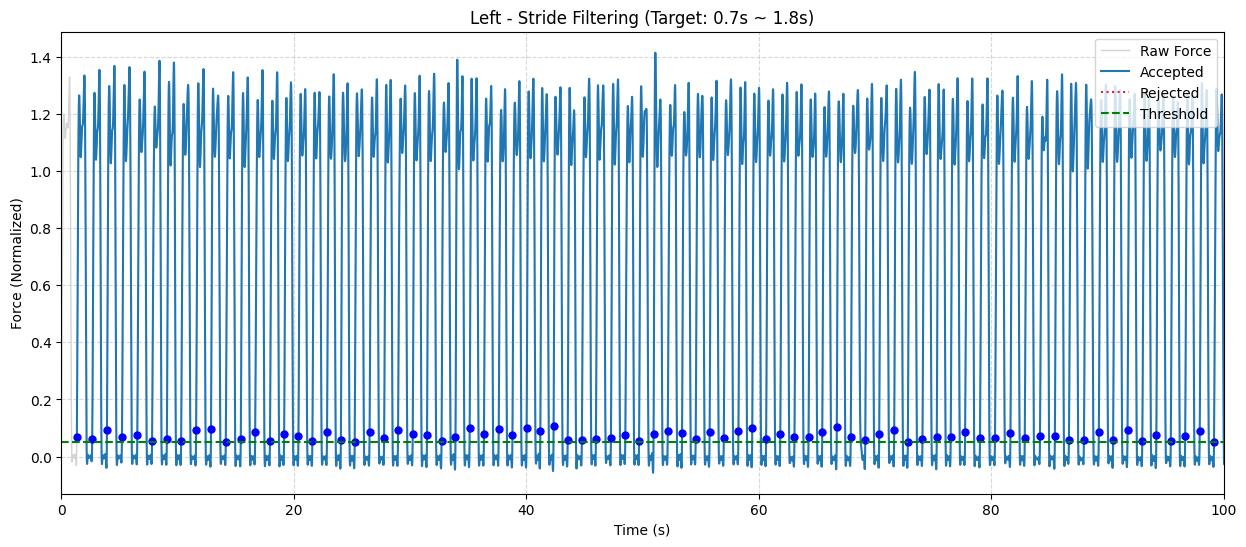


[Right] Processing Result:
  Total Detections : 240
  Accepted Strides : 238 (Range: 0.7-1.8s)
  Rejected Strides : 0


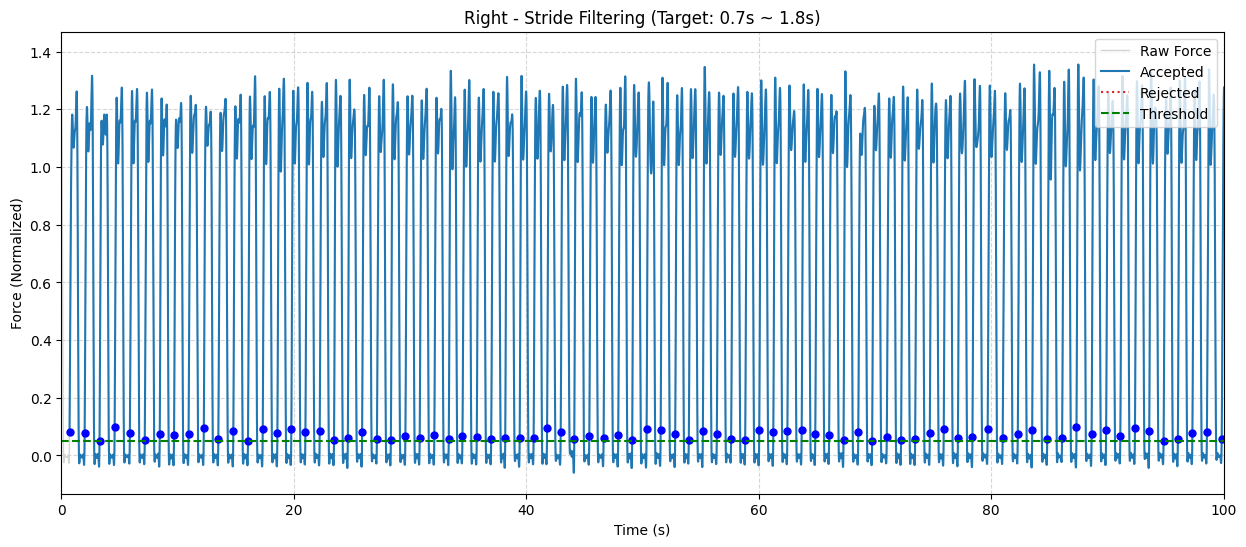

In [282]:
def detect_fz_heel_strikes(signal_array, threshold=0.05, min_dist_samples=40):
    """
    Fzの立ち上がり検出 
    """
    is_contact = signal_array > threshold
    rising_edge = np.diff(is_contact.astype(int), prepend=0) == 1
    potential_indices = np.where(rising_edge)[0]
    
    if len(potential_indices) == 0:
        return np.array([])

    true_indices = [potential_indices[0]]
    for idx in potential_indices[1:]:
        if idx - true_indices[-1] > min_dist_samples:
            true_indices.append(idx)
            
    return np.array(true_indices)

def slice_strides_with_constraints(df_input, target_col, side_name="Left", 
                                   threshold=0.05, fs=100, 
                                   min_duration=0.7, max_duration=1.8, 
                                   show_plot=True):
    """
    ストライド時間の制約を満たす歩行のみを抽出し、
    除外された長さはコンソールにのみ表示する関数
    """
    signal = df_input[target_col].values
    time_array = df_input['Time (Seconds)'].values
    
    min_dist_samples = int(0.4 * fs)
    
    # 1. 接地候補を検出
    hs_indices = detect_fz_heel_strikes(signal, threshold=threshold, min_dist_samples=min_dist_samples)
    
    valid_strides = []      # 採用リスト
    rejected_intervals = [] # 除外リスト (start, end, duration)
    valid_intervals = []    # 採用区間情報 (start, end)

    # 2. ストライドごとに時間を測ってフィルタリング(はじめと最後のストライドを除外)
    for i in range(1, len(hs_indices) - 2):
        start_idx = hs_indices[i]
        end_idx = hs_indices[i+1]
        
        start_t = time_array[start_idx]
        end_t = time_array[end_idx]
        duration = end_t - start_t
        
        # --- 判定ロジック ---
        if min_duration <= duration <= max_duration:
            # 採用
            stride_df = df_input.iloc[start_idx:end_idx].copy()
            valid_strides.append(stride_df)
            valid_intervals.append((start_t, end_t))
        else:
            # 不採用
            rejected_intervals.append((start_t, end_t, duration))

    # --- 結果の表示 (コンソール) ---
    print(f"\n[{side_name}] Processing Result:")
    print(f"  Total Detections : {len(hs_indices)-1}")
    print(f"  Accepted Strides : {len(valid_strides)} (Range: {min_duration}-{max_duration}s)")
    print(f"  Rejected Strides : {len(rejected_intervals)}")
    
    if rejected_intervals:
        # 除外された秒数をリスト化して表示
        rej_durations = [round(r[2], 3) for r in rejected_intervals]
        print(f"  -> Rejected Durations (sec): {rej_durations}")

    # --- 結果の可視化 (プロット) ---
    if show_plot and len(hs_indices) > 0:
        plt.figure(figsize=(15, 6))
        
        # 全体波形
        plt.plot(time_array, signal, color='lightgray', label='Raw Force', linewidth=1)
        
        # 採用区間 (青)
        for (t_s, t_e) in valid_intervals:
            mask = (time_array >= t_s) & (time_array <= t_e)
            plt.plot(time_array[mask], signal[mask], color='tab:blue', linewidth=1.5)
            # 開始点
            idx_s = np.searchsorted(time_array, t_s)
            plt.plot(t_s, signal[idx_s], 'bo', markersize=5)

        # 除外区間 (赤・点線) - テキストは表示しない
        for (t_s, t_e, dur) in rejected_intervals:
            mask = (time_array >= t_s) & (time_array <= t_e)
            plt.plot(time_array[mask], signal[mask], color='tab:red', linestyle=':', alpha=0.8)

        # 凡例・ラベル
        plt.plot([], [], color='tab:blue', label='Accepted')
        plt.plot([], [], color='tab:red', linestyle=':', label='Rejected')
        plt.axhline(y=threshold, color='green', linestyle='--', label='Threshold')

        plt.title(f"{side_name} - Stride Filtering (Target: {min_duration}s ~ {max_duration}s)")
        plt.xlabel("Time (s)")
        plt.ylabel("Force (Normalized)")
        plt.legend(loc='upper right')
        
        # 最初の30秒を表示
        display_end = min(time_array[-1], time_array[0] + 30)
        plt.xlim(0,100)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

    return valid_strides

# ==========================================
# 実行
# ==========================================
FORCE_THRESHOLD = 0.05

# 左足
left_strides_clean = slice_strides_with_constraints(
    df_input=df_final_analysis,
    target_col='Left_Fz',
    side_name="Left",
    threshold=FORCE_THRESHOLD,
    show_plot=True
)

# 右足
right_strides_clean = slice_strides_with_constraints(
    df_input=df_final_analysis,
    target_col='Right_Fz',
    side_name="Right",
    threshold=FORCE_THRESHOLD,
    show_plot=True
)

In [283]:
# ==========================================
# 1. カラム定義
# ==========================================
# 左側のカラムリスト（Time以外）
cols_left = [
    'Left_Pressure_1', 'Left_Pressure_2', 'Left_Pressure_3', 'Left_Pressure_4', 
    'Left_Pressure_5', 'Left_Pressure_6', 'Left_Pressure_7', 'Left_Pressure_8',
    'Left_Accel_X', 'Left_Accel_Y', 'Left_Accel_Z', 
    'Left_Gyro_X', 'Left_Gyro_Y', 'Left_Gyro_Z', 
    'Left_Hip_XY', 'Left_Hip_YZ', 'Left_Hip_ZX', 
    'Left_Knee_XY', 'Left_Knee_YZ', 'Left_Knee_ZX', 
    'Left_Ankle_XY', 'Left_Ankle_YZ', 'Left_Ankle_ZX', 
    'Left_Fx', 'Left_Fy', 'Left_Fz'
]

# 右側のカラムリスト（Left→Right, L_→R_ に置換）
cols_right = [c.replace('Left', 'Right') for c in cols_left]

# ==========================================
# 2. 正規化関数の定義
# ==========================================
def normalize_strides(stride_list, target_cols, n_points=200):
    """
    各ストライドのデータを0-100% (n_points) に正規化する関数
    
    Returns:
        normalized_dfs: 正規化されたDataFrameのリスト
        ensemble_array: 計算用3次元配列 (ストライド数 x 200 x カラム数)
    """
    normalized_dfs = []
    
    # データ格納用リスト（後で3次元配列にするため）
    data_collector = []

    # 0%から100%までの新しい時間軸
    gait_cycle = np.linspace(0, 100, n_points)
    
    # 補間用の新しいx軸 (0.0 ～ 1.0)
    x_new = np.linspace(0, 1, n_points)

    for stride_df in stride_list:
        # このストライドのデータ長
        n_len = len(stride_df)
        
        # 元のx軸 (0.0 ～ 1.0)
        x_old = np.linspace(0, 1, n_len)
        
        # 新しいDataFrame作成
        new_df = pd.DataFrame()
        new_df['Gait Cycle (%)'] = gait_cycle
        
        # 各カラムを補間
        stride_matrix = [] # このストライドの数値データ行列
        
        for col in target_cols:
            if col in stride_df.columns:
                y_old = stride_df[col].values
                
                # 線形補間関数を作成
                f = interp1d(x_old, y_old, kind='linear', fill_value="extrapolate")
                
                # 新しいデータ点での値を取得
                y_new = f(x_new)
                
                new_df[col] = y_new
                stride_matrix.append(y_new)
            else:
                # カラムが無い場合の安全策（全て0埋めなど）
                print(f"Warning: Column {col} not found in stride data.")
                zeros = np.zeros(n_points)
                new_df[col] = zeros
                stride_matrix.append(zeros)
        
        normalized_dfs.append(new_df)
        
        # 転置して (200, カラム数) の形にする
        data_collector.append(np.array(stride_matrix).T)

    # 3次元配列に変換 (ストライド数, 200, カラム数)
    if len(data_collector) > 0:
        ensemble_array = np.array(data_collector)
    else:
        ensemble_array = np.empty((0, n_points, len(target_cols)))

    return normalized_dfs, ensemble_array

# ==========================================
# 3. 実行
# ==========================================

# 左足の正規化
left_norm_dfs, left_ensemble = normalize_strides(
    left_strides_clean, 
    cols_left, 
    n_points=200
)

# 右足の正規化
right_norm_dfs, right_ensemble = normalize_strides(
    right_strides_clean, 
    cols_right, 
    n_points=200
)

# --- 結果の確認 ---
print(f"Left Normalized Strides: {len(left_norm_dfs)}")
print(f"Left Ensemble Shape: {left_ensemble.shape}  (Strides, Points, Features)")

print(f"Right Normalized Strides: {len(right_norm_dfs)}")
print(f"Right Ensemble Shape: {right_ensemble.shape} (Strides, Points, Features)")

# 左足のカラム名を確認
if len(left_norm_dfs) > 0:
    print("=== Left Normalized Columns ===")
    print(left_norm_dfs[0].columns.tolist())

# 右足のカラム名を確認
if len(right_norm_dfs) > 0:
    print("\n=== Right Normalized Columns ===")
    print(right_norm_dfs[0].columns.tolist())

Left Normalized Strides: 237
Left Ensemble Shape: (237, 200, 26)  (Strides, Points, Features)
Right Normalized Strides: 238
Right Ensemble Shape: (238, 200, 26) (Strides, Points, Features)
=== Left Normalized Columns ===
['Gait Cycle (%)', 'Left_Pressure_1', 'Left_Pressure_2', 'Left_Pressure_3', 'Left_Pressure_4', 'Left_Pressure_5', 'Left_Pressure_6', 'Left_Pressure_7', 'Left_Pressure_8', 'Left_Accel_X', 'Left_Accel_Y', 'Left_Accel_Z', 'Left_Gyro_X', 'Left_Gyro_Y', 'Left_Gyro_Z', 'Left_Hip_XY', 'Left_Hip_YZ', 'Left_Hip_ZX', 'Left_Knee_XY', 'Left_Knee_YZ', 'Left_Knee_ZX', 'Left_Ankle_XY', 'Left_Ankle_YZ', 'Left_Ankle_ZX', 'Left_Fx', 'Left_Fy', 'Left_Fz']

=== Right Normalized Columns ===
['Gait Cycle (%)', 'Right_Pressure_1', 'Right_Pressure_2', 'Right_Pressure_3', 'Right_Pressure_4', 'Right_Pressure_5', 'Right_Pressure_6', 'Right_Pressure_7', 'Right_Pressure_8', 'Right_Accel_X', 'Right_Accel_Y', 'Right_Accel_Z', 'Right_Gyro_X', 'Right_Gyro_Y', 'Right_Gyro_Z', 'Right_Hip_XY', 'Right_Hip

In [284]:
def filter_outlier_strides(ensemble_array, stride_dfs, n_sigmas=3, outlier_ratio_threshold=0.05):
    """
    全ストライドの中央値から大きく乖離している「外れ値ストライド」を除外する関数
    
    Parameters:
    - ensemble_array: 3次元配列 (ストライド数, 200, カラム数)
    - stride_dfs: 正規化済みDataFrameのリスト (長さはストライド数と同じ)
    - n_sigmas: 閾値 (標準偏差の何倍を許容するか。通常3)
    - outlier_ratio_threshold: 
        1ストライドの中で、全データ点のうち何割が閾値を超えたら「除外」とするか。
        0.0 (0%)  -> 1点でも外れたら即除外 (厳格)
        0.05 (5%) -> 全体の5%以上の点が外れていたら除外 (ノイズ許容)
        
    Returns:
    - clean_ensemble: 除外後の3次元配列
    - clean_dfs: 除外後のDataFrameリスト
    - keep_indices: どのインデックスを残したかのBoolean配列
    """
    
    # 1. 集団の基準を作成 (各時間点・各カラムごとの中央値と標準偏差)
    # axis=0 は「ストライド方向」に計算することを意味します
    median_curve = np.median(ensemble_array, axis=0) # Shape: (200, cols)
    std_curve = np.std(ensemble_array, axis=0)       # Shape: (200, cols)
    
    # 2. 許容範囲 (トンネル) を定義
    upper_limit = median_curve + (n_sigmas * std_curve)
    lower_limit = median_curve - (n_sigmas * std_curve)
    
    # ブロードキャスト計算のために次元を合わせる
    # upper_limit shape: (1, 200, cols)
    upper_limit_bc = upper_limit[np.newaxis, :, :]
    lower_limit_bc = lower_limit[np.newaxis, :, :]
    
    # 3. 外れ値判定 (Trueなら外れ値)
    # Shape: (ストライド数, 200, カラム数)
    is_outlier_matrix = (ensemble_array > upper_limit_bc) | (ensemble_array < lower_limit_bc)
    
    # 4. ストライドごとの判定
    # 各ストライドにおいて、「外れ値」と判定されたデータ点の総数をカウント
    # axis=(1, 2) で 時間×カラム 全体での外れ値数を数えます
    total_points_per_stride = ensemble_array.shape[1] * ensemble_array.shape[2]
    outlier_counts = np.sum(is_outlier_matrix, axis=(1, 2))
    
    # 外れ値の割合を計算
    outlier_ratios = outlier_counts / total_points_per_stride
    
    # 閾値を超えているストライドは False (削除), それ以外は True (保持)
    keep_mask = outlier_ratios <= outlier_ratio_threshold
    
    # 5. フィルタリング実行
    clean_ensemble = ensemble_array[keep_mask]
    
    # DataFrameリストも同じマスクでフィルタリング
    clean_dfs = [df for i, df in enumerate(stride_dfs) if keep_mask[i]]
    
    return clean_ensemble, clean_dfs, keep_mask

# ==========================================
# 実行部分
# ==========================================

# 左足のクリーニング
# outlier_ratio_threshold=0.01 (全体の1%以上の点が異常ならそのストライドを捨てる)
L_ens_clean, L_dfs_clean, L_mask = filter_outlier_strides(
    left_ensemble, 
    left_norm_dfs, 
    n_sigmas=3, 
    outlier_ratio_threshold=0.01 
)

# 右足のクリーニング
R_ens_clean, R_dfs_clean, R_mask = filter_outlier_strides(
    right_ensemble, 
    right_norm_dfs, 
    n_sigmas=3, 
    outlier_ratio_threshold=0.01
)

# --- 結果確認 ---
print("=== Cleaning Result ===")
print(f"Left Stride Count:  {len(left_norm_dfs)} -> {len(L_dfs_clean)} (Removed: {len(left_norm_dfs) - len(L_dfs_clean)})")
print(f"Right Stride Count: {len(right_norm_dfs)} -> {len(R_dfs_clean)} (Removed: {len(right_norm_dfs) - len(R_dfs_clean)})")

print(f"Left Ensemble Shape: {L_ens_clean.shape}")
print(f"Right Ensemble Shape: {R_ens_clean.shape}")

=== Cleaning Result ===
Left Stride Count:  237 -> 182 (Removed: 55)
Right Stride Count: 238 -> 181 (Removed: 57)
Left Ensemble Shape: (182, 200, 26)
Right Ensemble Shape: (181, 200, 26)


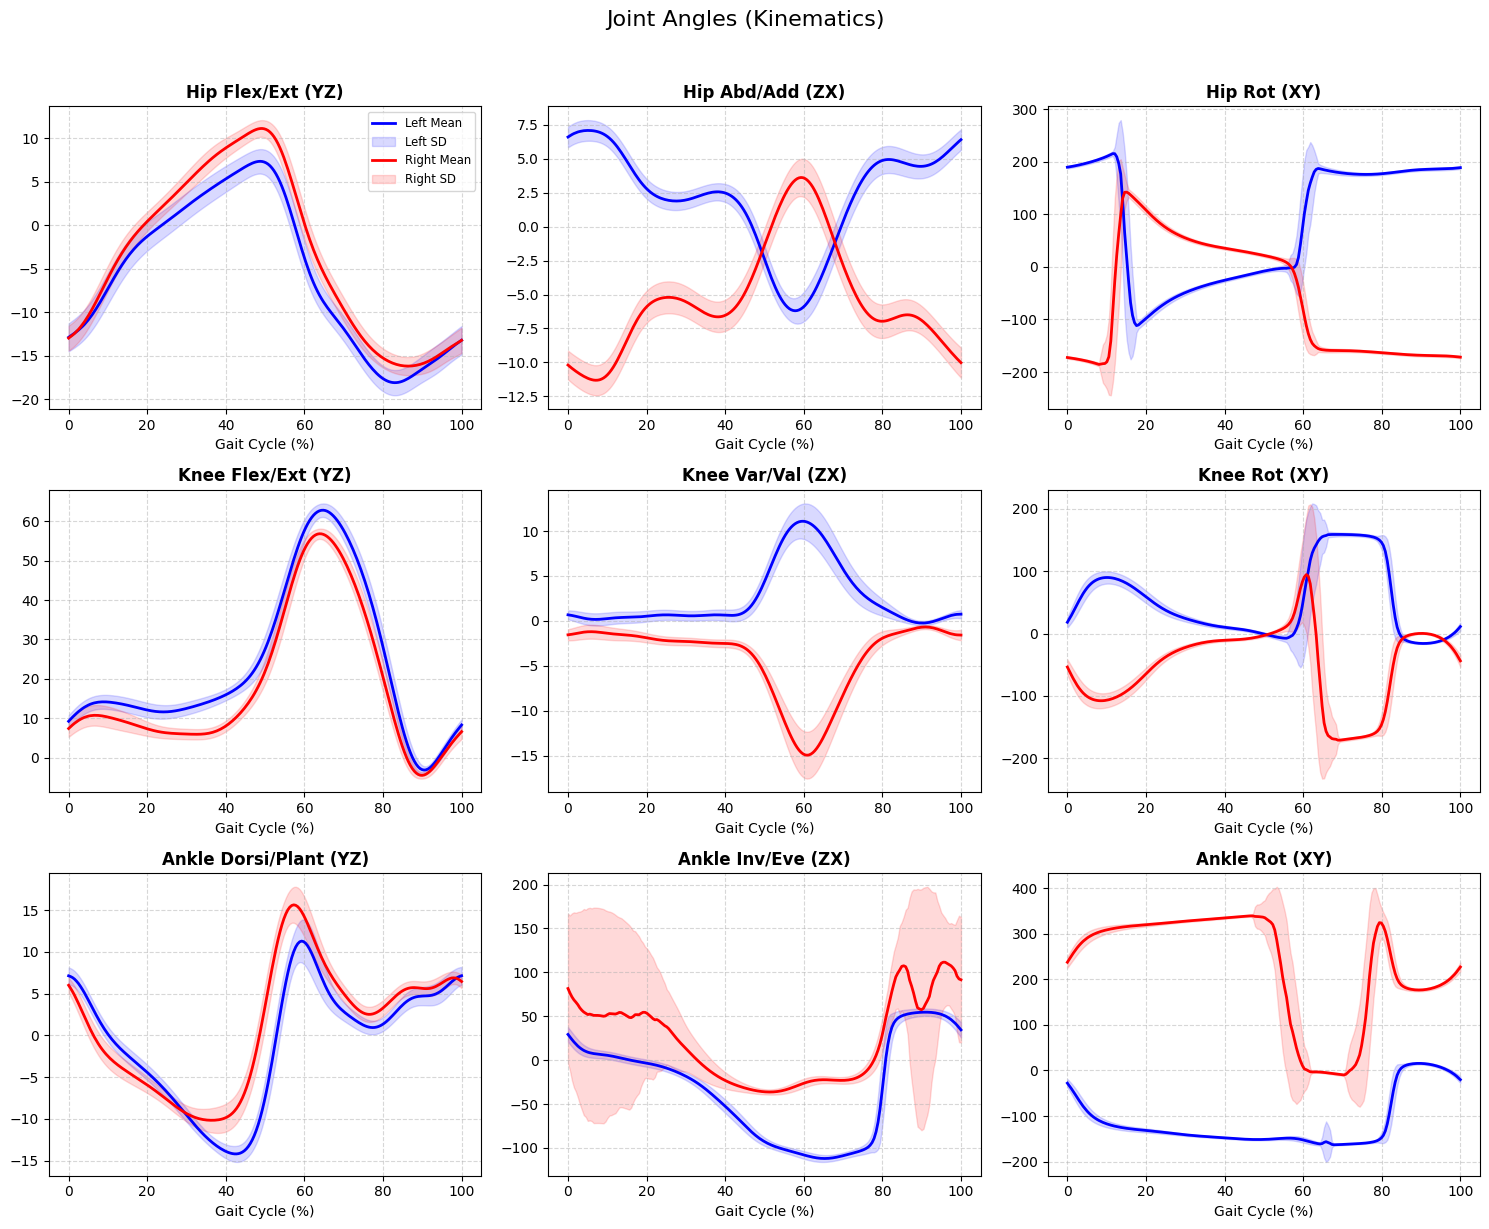

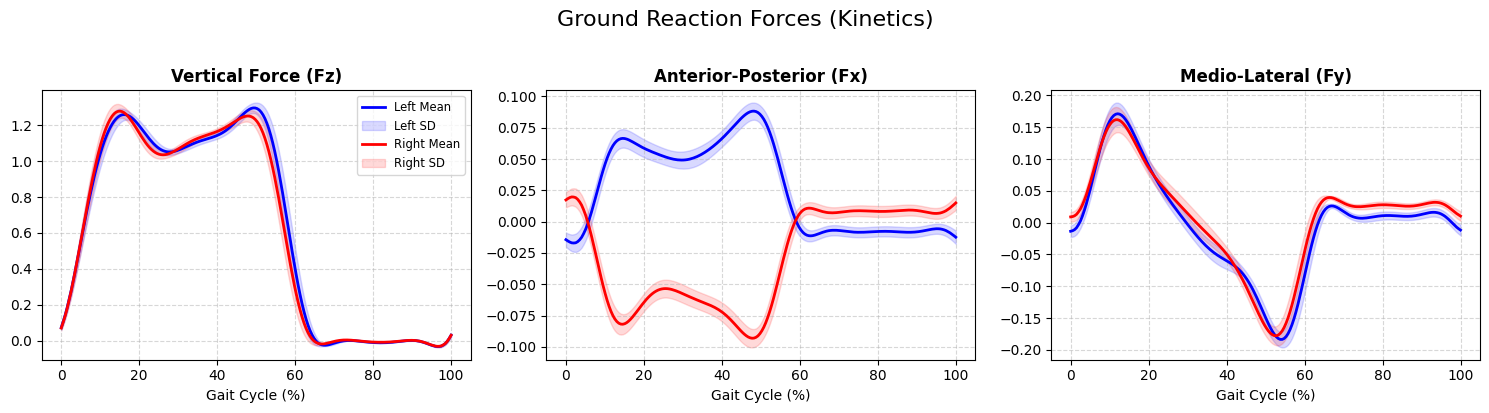

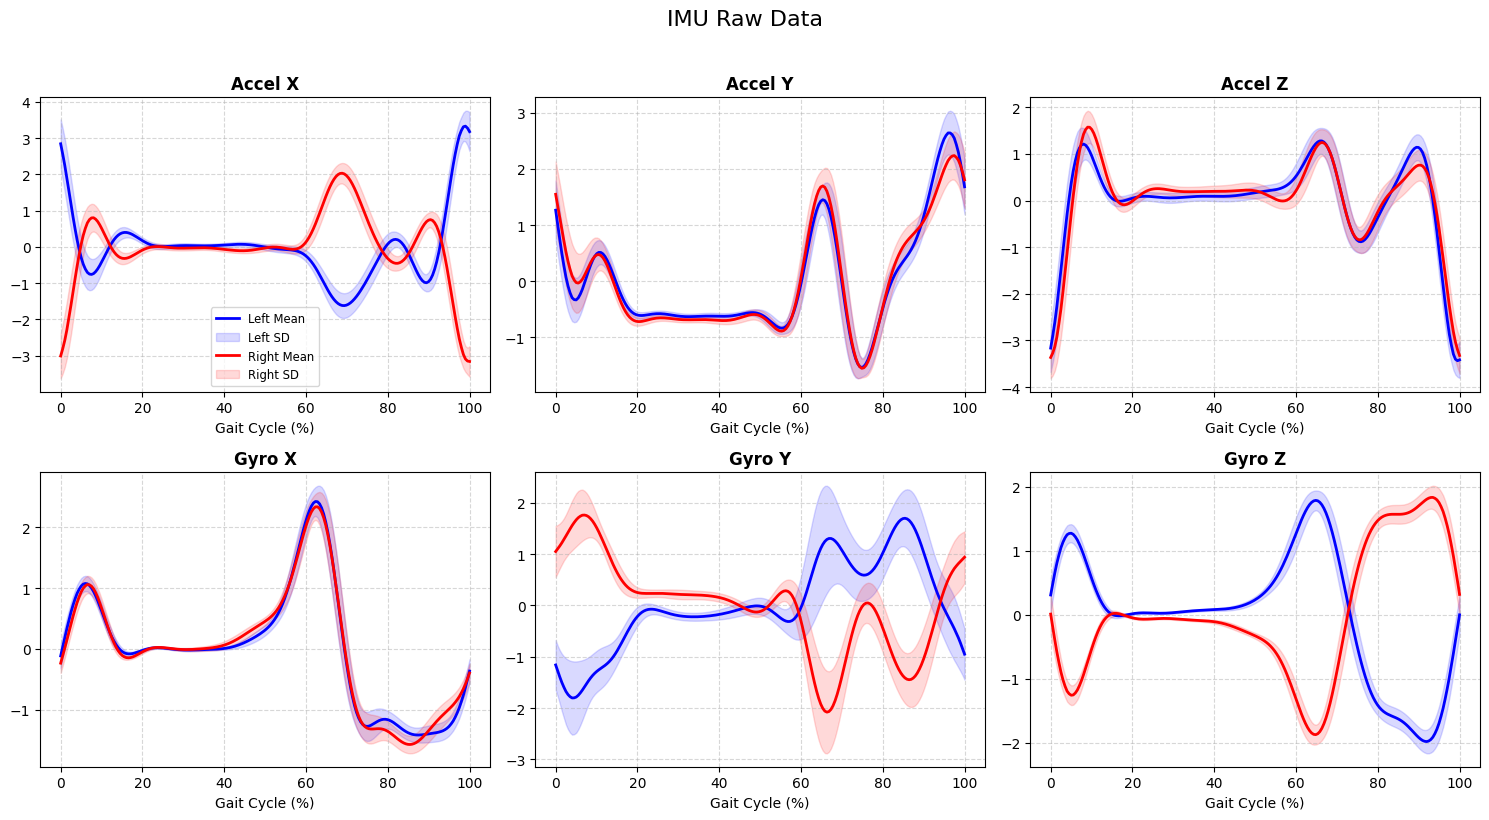

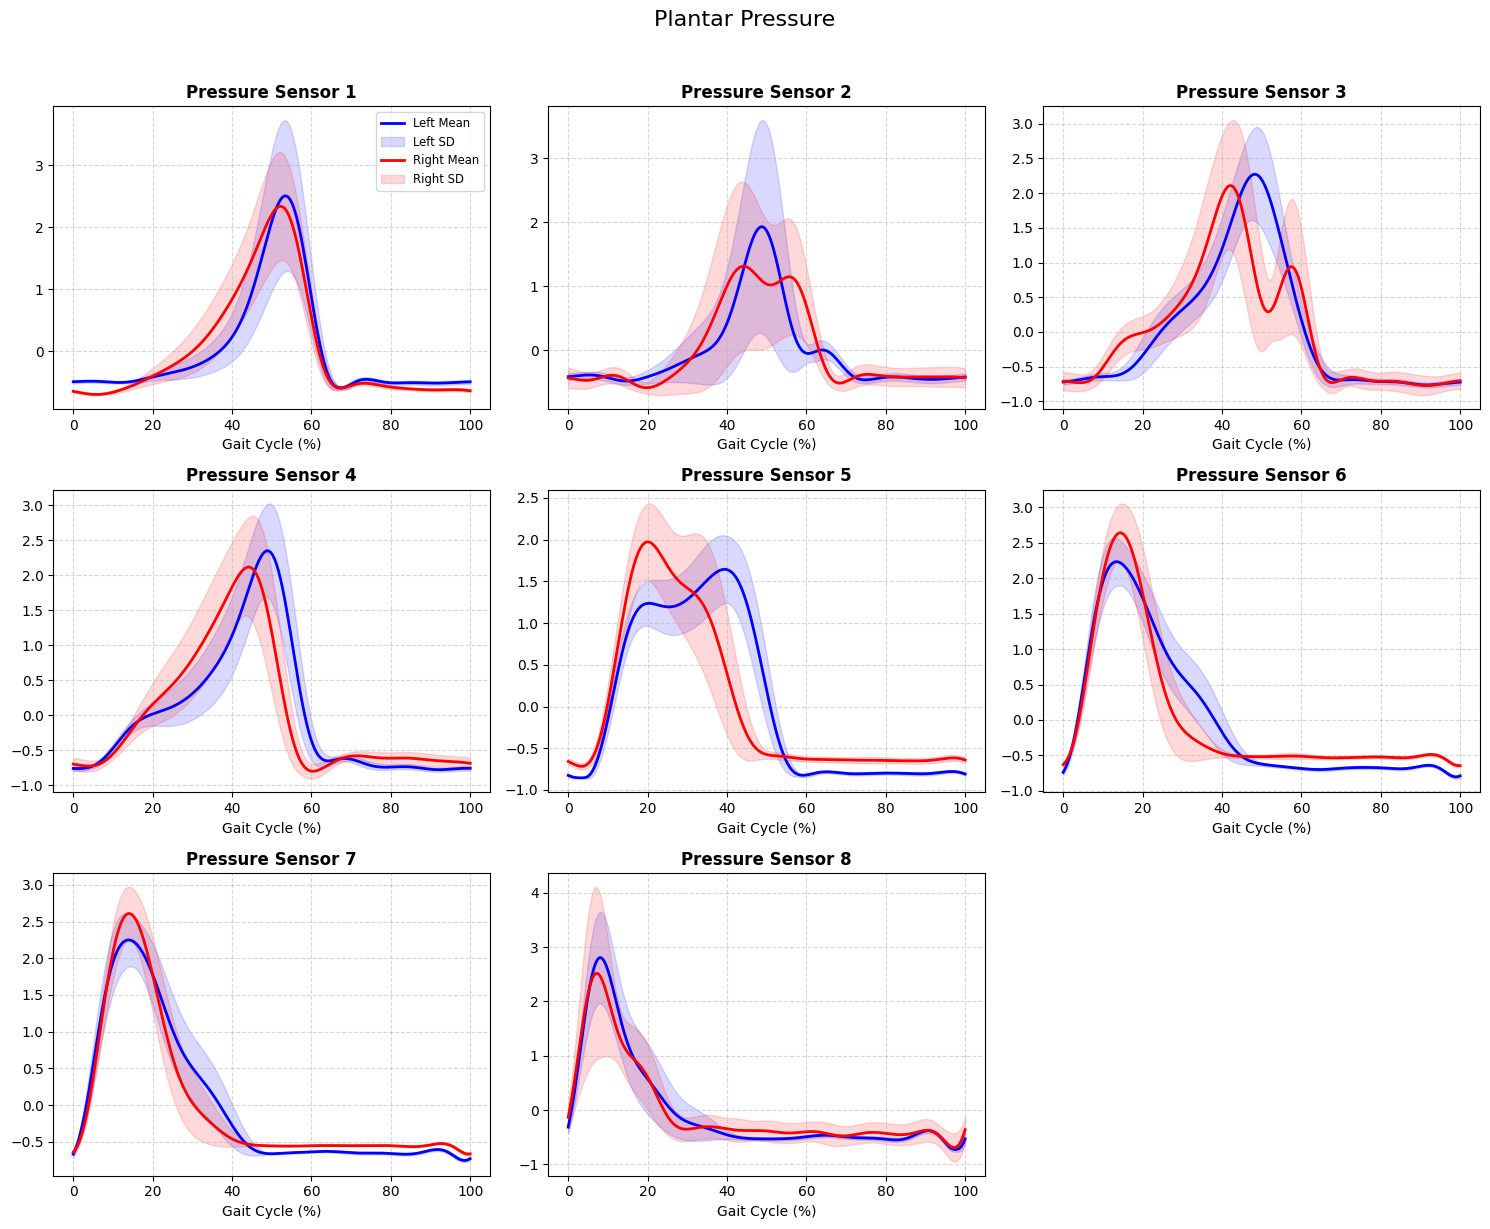

In [287]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gait_comparison(left_ensemble, right_ensemble, 
                         left_cols, right_cols, 
                         target_features_map, 
                         title="Gait Analysis"):
    """
    左右の正規化データを比較プロットする関数
    
    Parameters:
    - left_ensemble, right_ensemble: (Strides, 200, Features) の3次元配列
    - left_cols, right_cols: カラム名のリスト
    - target_features_map: プロットしたい項目の辞書 {'タイトル': ('Left名', 'Right名')}
    """
    
    # プロットの行・列数を計算
    n_plots = len(target_features_map)
    n_cols = 3
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()
    
    # 0-100% の軸
    x = np.linspace(0, 100, 200)
    
    for i, (plot_title, (l_col, r_col)) in enumerate(target_features_map.items()):
        ax = axes[i]
        
        # --- 左足 (Blue) ---
        if l_col in left_cols:
            idx = left_cols.index(l_col)
            # 全ストライドのデータ (N, 200)
            data_l = left_ensemble[:, :, idx]
            
            mean_l = np.mean(data_l, axis=0)
            std_l = np.std(data_l, axis=0)
            
            ax.plot(x, mean_l, color='blue', label='Left Mean', linewidth=2)
            ax.fill_between(x, mean_l - std_l, mean_l + std_l, color='blue', alpha=0.15, label='Left SD')
            
        # --- 右足 (Red) ---
        if r_col in right_cols:
            idx = right_cols.index(r_col)
            # 全ストライドのデータ (N, 200)
            data_r = right_ensemble[:, :, idx]
            
            mean_r = np.mean(data_r, axis=0)
            std_r = np.std(data_r, axis=0)
            
            ax.plot(x, mean_r, color='red', label='Right Mean', linewidth=2)
            ax.fill_between(x, mean_r - std_r, mean_r + std_r, color='red', alpha=0.15, label='Right SD')

        ax.set_title(plot_title, fontsize=12, fontweight='bold')
        ax.set_xlabel("Gait Cycle (%)")
        ax.grid(True, linestyle='--', alpha=0.5)
        
        # 凡例は最初のグラフにだけ表示（ごちゃつき防止）
        if i == 0:
            ax.legend(loc='best', fontsize='small')

    # 余ったサブプロットを消す
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# ==========================================
# 1. 関節角度の可視化 (Joint Angles)
# ==========================================
# 表示したいペアを定義 {'グラフタイトル': ('左カラム名', '右カラム名')}
angle_map = {
    # 屈曲・伸展 (Flexion/Extension) -> 矢状面 (Sagittal) -> YZ
    'Hip Flex/Ext (YZ)':   ('Left_Hip_YZ', 'Right_Hip_YZ'),
    # 外転・内転 (Abduction/Adduction) -> 前額面 (Frontal) -> ZX
    'Hip Abd/Add (ZX)':    ('Left_Hip_ZX', 'Right_Hip_ZX'),
    # 回旋 (Rotation) -> 水平面 (Horizontal) -> XY
    'Hip Rot (XY)':        ('Left_Hip_XY', 'Right_Hip_XY'),
    
    # 膝関節
    'Knee Flex/Ext (YZ)':  ('Left_Knee_YZ', 'Right_Knee_YZ'),
    'Knee Var/Val (ZX)':   ('Left_Knee_ZX', 'Right_Knee_ZX'), # 内反・外反は前額面
    'Knee Rot (XY)':       ('Left_Knee_XY', 'Right_Knee_XY'), # 回旋は水平面

    # 足関節
    'Ankle Dorsi/Plant (YZ)': ('Left_Ankle_YZ', 'Right_Ankle_YZ'), # 背屈・底屈は矢状面
    'Ankle Inv/Eve (ZX)':     ('Left_Ankle_ZX', 'Right_Ankle_ZX'), # 内返し・外返しは主に前額面（または複合）
    'Ankle Rot (XY)':         ('Left_Ankle_XY', 'Right_Ankle_XY'), # 外転・内転（回旋要素）
}

plot_gait_comparison(
    L_ens_clean, R_ens_clean, 
    cols_left, cols_right, 
    angle_map, 
    title="Joint Angles (Kinematics)"
)

# ==========================================
# 2. 床反力の可視化 (Ground Reaction Forces)
# ==========================================
force_map = {
    'Vertical Force (Fz)': ('Left_Fz', 'Right_Fz'),
    'Anterior-Posterior (Fx)': ('Left_Fx', 'Right_Fx'),
    'Medio-Lateral (Fy)':  ('Left_Fy', 'Right_Fy'),
}

plot_gait_comparison(
    L_ens_clean, R_ens_clean, 
    cols_left, cols_right, 
    force_map, 
    title="Ground Reaction Forces (Kinetics)"
)

# ==========================================
# 3. IMUデータの可視化 (Accel & Gyro)
# ==========================================
imu_map = {
    'Accel X': ('Left_Accel_X', 'Right_Accel_X'),
    'Accel Y': ('Left_Accel_Y', 'Right_Accel_Y'),
    'Accel Z': ('Left_Accel_Z', 'Right_Accel_Z'),
    'Gyro X':  ('Left_Gyro_X', 'Right_Gyro_X'),
    'Gyro Y':  ('Left_Gyro_Y', 'Right_Gyro_Y'),
    'Gyro Z':  ('Left_Gyro_Z', 'Right_Gyro_Z'),
}

plot_gait_comparison(
    L_ens_clean, R_ens_clean, 
    cols_left, cols_right, 
    imu_map, 
    title="IMU Raw Data"
)

# ==========================================
# 4. 足底圧の可視化 (Plantar Pressure)
# ==========================================
# センサー1〜8の左右比較マップを作成
pressure_map = {}
for i in range(1, 9):
    pressure_map[f'Pressure Sensor {i}'] = (f'Left_Pressure_{i}', f'Right_Pressure_{i}')

# プロット実行
plot_gait_comparison(
    L_ens_clean, R_ens_clean, 
    cols_left, cols_right, 
    pressure_map, 
    title="Plantar Pressure"
)

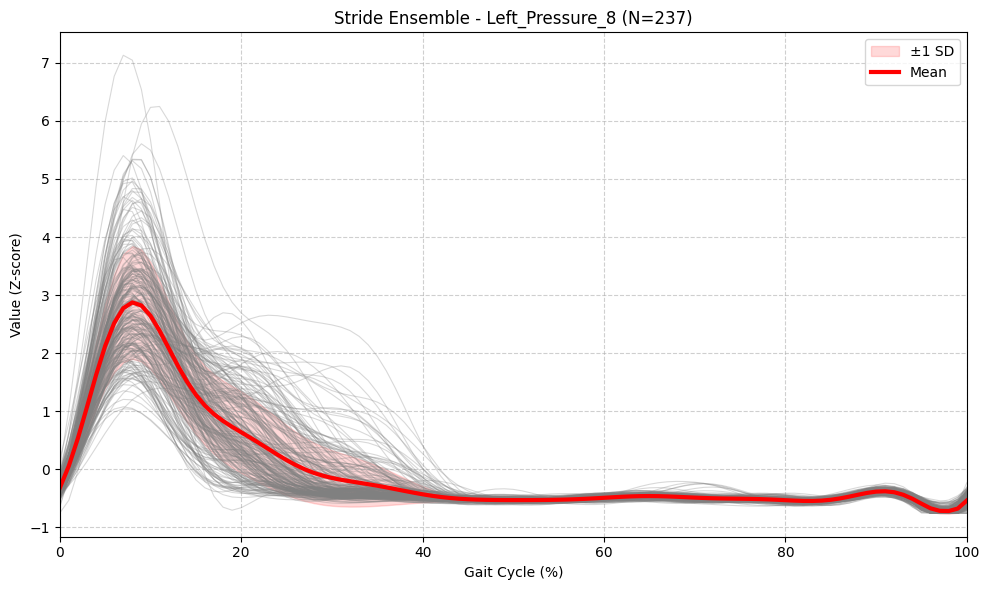

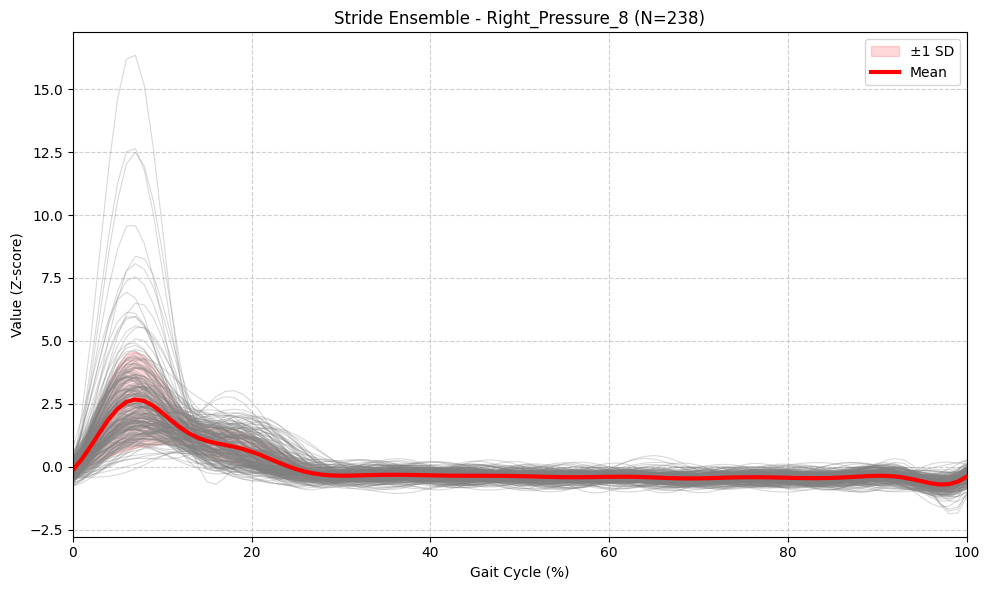

In [286]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ensemble_strides(stride_list, target_col, title="Stride Ensemble", unit="Z-score", y_limits=None):
    """
    複数のストライドデータを0-100%に正規化して重ね書きする関数
    
    Parameters:
    - stride_list: 切り出されたDataFrameのリスト
    - target_col: プロットしたいカラム名
    - title: グラフのタイトル
    - unit: Y軸の単位ラベル
    - y_limits: Y軸の範囲指定 (min, max) ※左右比較などで範囲を揃えたい時に使用
    """
    if not stride_list:
        print(f"No strides to plot for {target_col}.")
        return

    # 正規化後のデータ点数
    norm_length = 101
    x_norm = np.linspace(0, 100, norm_length)
    
    ensemble_data = []

    plt.figure(figsize=(10, 6))

    # --- 1. 個別のストライドをプロット ---
    # データ処理とプロットを分け、アンサンブル計算を先に行うことも可能ですが、
    # 視覚的には薄いグレー(個別)の上に赤(平均)が来るように描画順を意識します。
    
    count = 0
    for df in stride_list:
        if target_col not in df.columns:
            continue
            
        y_values = df[target_col].values
        
        if len(y_values) < 2:
            continue

        # 時間軸の正規化
        x_original = np.linspace(0, 100, len(y_values))
        y_interp = np.interp(x_norm, x_original, y_values)
        
        ensemble_data.append(y_interp)
        count += 1

        # 個別データのプロット
        plt.plot(x_norm, y_interp, color='gray', alpha=0.3, linewidth=0.8)

    # --- 2. 平均波形の計算とプロット ---
    if ensemble_data:
        ensemble_matrix = np.array(ensemble_data)
        
        mean_waveform = np.mean(ensemble_matrix, axis=0)
        std_waveform = np.std(ensemble_matrix, axis=0)
        
        # 標準偏差の範囲（塗りつぶし）- 平均線の下に描画されるようzorder調整も有効ですが、今回は順序で対応
        plt.fill_between(x_norm, 
                         mean_waveform - std_waveform, 
                         mean_waveform + std_waveform, 
                         color='red', alpha=0.15, label='±1 SD')
        
        # 平均値
        plt.plot(x_norm, mean_waveform, color='red', linewidth=3, label='Mean')

    # --- 3. グラフの装飾 ---
    # タイトルにデータ数(N)を含めるのが研究用グラフのポイントです
    plt.title(f"{title} - {target_col} (N={count})")
    plt.xlabel("Gait Cycle (%)")
    plt.ylabel(f"Value ({unit})")
    plt.xlim(0, 100)
    
    # Y軸範囲の指定があれば適用（左右の足を比較する際などに便利）
    if y_limits:
        plt.ylim(y_limits)
        
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='best') # 凡例の位置を自動調整
    
    # 一般的に立脚相と遊脚相の境目（約60%）に目安線を入れることもあります（必要に応じて）
    # plt.axvline(x=60, color='black', linestyle=':', alpha=0.5, label='Toe Off approx.')

    plt.tight_layout() # レイアウトの自動調整
    plt.show()

# ==========================================
# 実行例（データ変数がメモリにあると仮定）
# ==========================================
# Left
plot_ensemble_strides(
    stride_list=left_strides_clean, 
    target_col='Left_Pressure_8', 
)

# Right
plot_ensemble_strides(
    stride_list=right_strides_clean, 
    target_col='Right_Pressure_8', 
)